<a href="https://colab.research.google.com/github/cliu-15/BE-205-Assn1/blob/main/final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cindy Liu, BE205
## Assn5 Progress Report:
Most of the current progress so far has been data pre-processing and identifying potential features / pre-trained models that would be helpful. Some of the pre-processing and feature extraction was done in MATLAB (using some existing lab code pipelines) and therefore not shown in this notebook. Moving forward, the focus will be on implementing transfer learning in my code and testing out various models (with either transfer learning, simple models for direct training/testing, or using extracted features). 
- Progress
    - Data pre-processing:
        - (Outside of this notebook): split whole breast images into 4 quadrants (each labeled as healthy=0 or tumor=1 depending on whether the quadrant contains a tumor), to increase the size of the dataset
        - Identified potential features of interest based on literature review + wrote feature extraction code (in MATLAB, outside of this notebook)
            - 1D features: mean, std, variance, range, IQR, mean absolute deviation (MAD), percentiles (25/50/75), skewness, kurtosis, GLCM (Gray-level cooccurrence matrix - contrast, correlation, energy, homogeneity), Hu's moments
            - 2D features: density, entropy, directionality, FD (fractal), branching, endpoints
    - Data augmentation: set-up basic code for augmenting data with rotation/translation/flipping/contrast -- necessary because of small dataset size
    - Training/testing: set-up simple tensorflow model for baseline
- Challenges
    - Transfer learning: best way to incorporate VinDr-Mammo external mammography dataset? (large dataset size)
    - Look into using pre-trained models as feature extractors
- Next steps
    - Data pre-processing: finish extracting features; account for class imbalance between healthy vs. tumor sections (potentially through data augmentation or selection) 
    - Transfer learning: use keras ResNet50 for transfer learning (freeze last few layers and train on dataset)
    - Training/testing: try simpler models with extracted features only

In [ ]:
import tensorflow as tf
#import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load data

In [ ]:
def load_data(folder):
    data = []
    labels = []
    for root, dirs, files in os.walk(folder):
        for filename in files:
            f = os.path.join(root, filename)
            if 'labeled_section' in f:
                img = scipy.io.loadmat(f)
                img = np.array(img['section_grayscale'])
                data.append(img)

                label = f.split('=')[1]
                label = int(label[0:1])
                labels.append(label)
    data = np.asarray(data)
    labels = np.asarray(labels)
    return data, labels

train_data, train_labels = load_data('breast_pact/train/')
test_data, test_labels = load_data('breast_pact/test')
print('Train data size: ' + str(np.shape(train_data)))
print('Train labels size: ' + str(np.shape(train_labels)))
print('Train data classes: ' + str(sum(train_labels == 0)) + ' healthy, ' + str(sum(train_labels == 1)) + ' tumor')
print('------------------------------------------')
print('Test data size: ' + str(np.shape(test_data)))
print('Test data size: ' + str(np.shape(test_labels)))
print('Test data classes: ' + str(sum(test_labels == 0)) + ' healthy, ' + str(sum(test_labels == 1)) + ' tumor')

Train data size: (72, 256, 256)
Train labels size: (72,)
Train data classes: 46 healthy, 26 tumor
------------------------------------------
Test data size: (28, 256, 256)
Test data size: (28,)
Test data classes: 23 healthy, 5 tumor


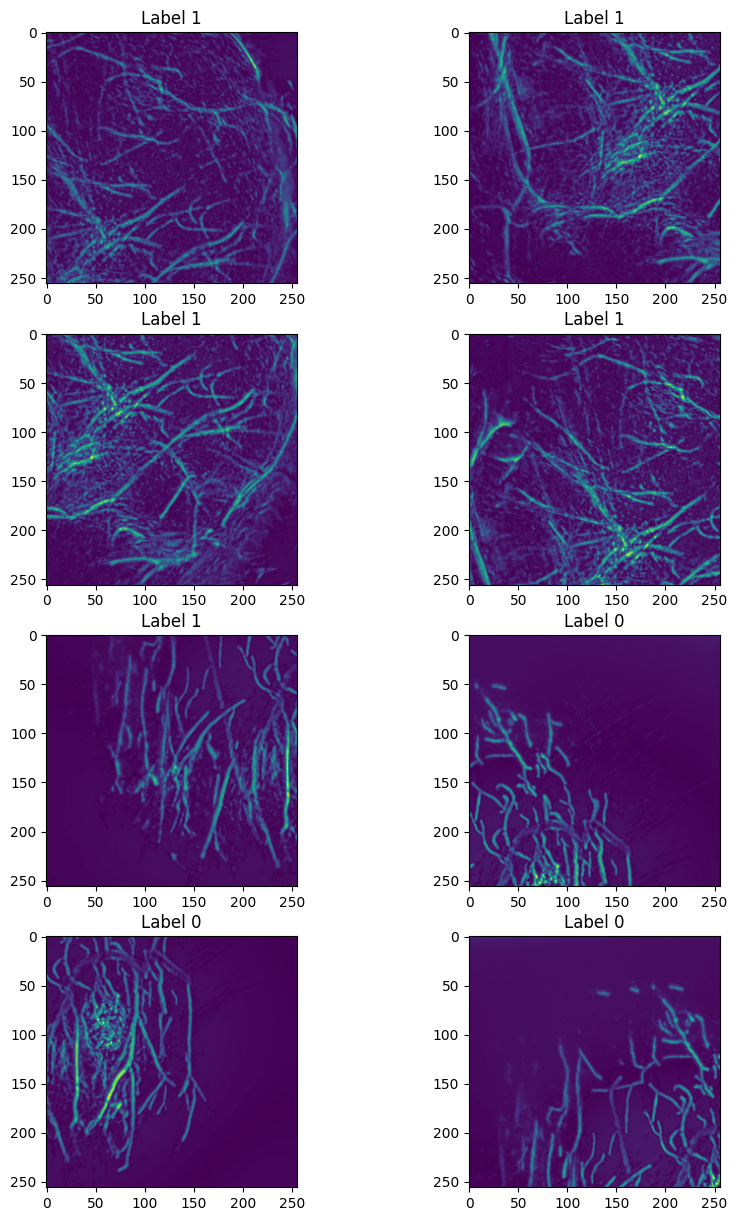

In [ ]:
# Visualize example images -- output hidden (patient privacy)
fig, axes = plt.subplots(4, 2, figsize=(10,15))
for i in range(8):
    axes.flatten()[i].imshow(train_data[i])
    axes.flatten()[i].set_title('Label ' + str(train_labels[i]))

## Pre-processing / Data augmentation

2023-06-02 23:12:04.571532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [72]
	 [[{{node Placeholder/_1}}]]


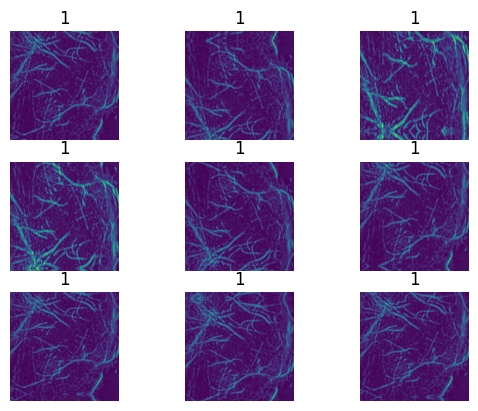

In [ ]:
# Data Augmentation -- output hidden (patient privacy)
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.2),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
)

train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

# Visualize augmented images
for image, label in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy())
        plt.title("{}".format(label.numpy()))
        plt.axis("off")

In [ ]:
def process_dataset(ds, augment = False, shuffle = True):
    # Augment data
    img_augmentation = Sequential([
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ])
    ds = ds.batch(1)
    if augment:
        augmented_ds = ds
        for i in range(6):
            augmented_imgs = ds.map(lambda x, y: (img_augmentation(x), y))
            augmented_ds = augmented_ds.concatenate(augmented_imgs) 
        ds = augmented_ds
        
    # Shuffle data
    if shuffle:
        ds = ds.shuffle(1000)

    # Rescale pixel values
    rescale = layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (rescale(x), y))
        
    return ds.prefetch(buffer_size = tf.data.AUTOTUNE)

2023-06-02 23:12:11.899506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_49' with dtype resource
	 [[{{node Placeholder/_49}}]]
2023-06-02 23:12:11.900827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_51' with dtype resource
	 [[{{node Placeholder/_51}}]]


Train dataset size: 504


2023-06-02 23:12:14.549415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_37' with dtype resource
	 [[{{node Placeholder/_37}}]]
2023-06-02 23:12:14.550686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_66' with dtype float and shape [72,256,256]
	 [[{{node Placeholder/_66}}]]


Train classes: 322 healthy, 182 tumor
----------------------------
Test dataset size: 28
Test classes: 23 healthy, 5 tumor


2023-06-02 23:12:17.030691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [28]
	 [[{{node Placeholder/_1}}]]
2023-06-02 23:12:17.031043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [28,256,256]
	 [[{{node Placeholder/_0}}]]
2023-06-02 23:12:17.059983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [28]

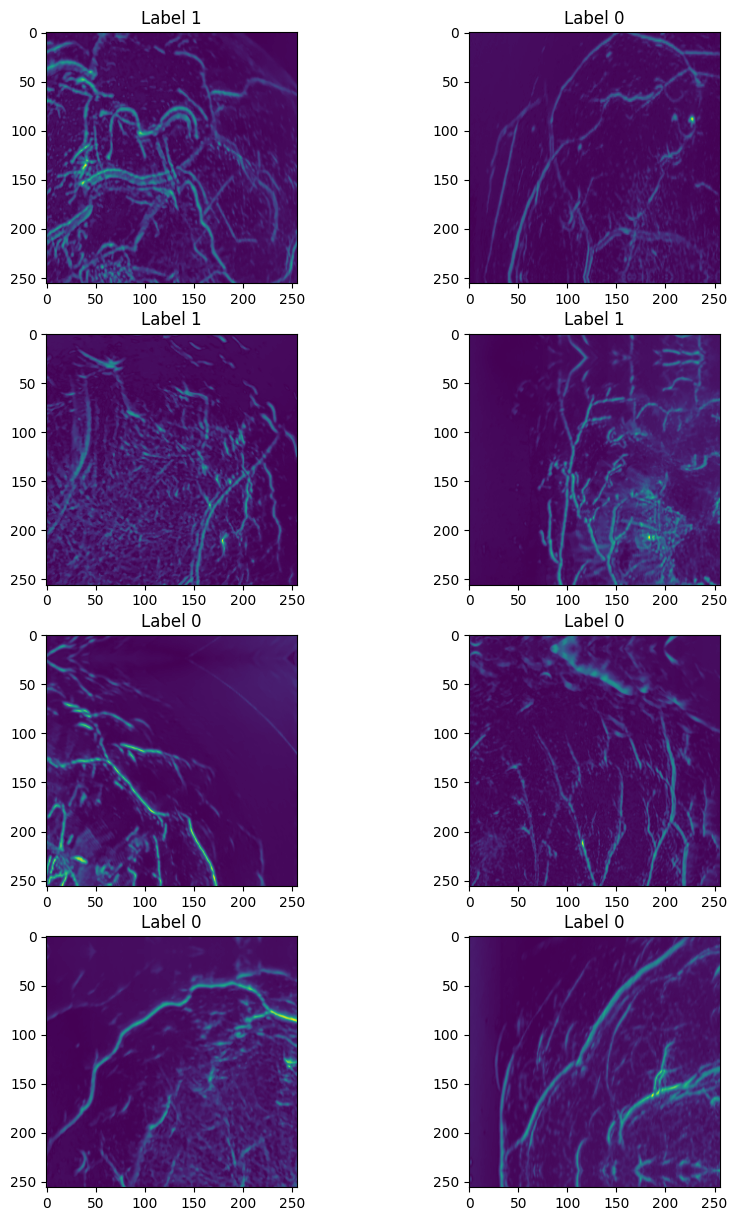

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_data, train_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

train_ds = process_dataset(train_ds, augment = True, shuffle = True)
test_ds = process_dataset(test_ds)

print('Train dataset size: ' + str(len(list(train_ds.map(lambda x, y: (x, y))))))
labels = np.concatenate([y for x, y in train_ds], axis = 0)
print('Train classes: ' + str(sum(labels == 0)) + ' healthy, ' + str(sum(labels == 1)) + ' tumor')
print('----------------------------')
print('Test dataset size: ' + str(len(list(test_ds.map(lambda x, y: (x, y))))))
labels = np.concatenate([y for x, y in test_ds], axis = 0)
print('Test classes: ' + str(sum(labels == 0)) + ' healthy, ' + str(sum(labels == 1)) + ' tumor')

fig, axes = plt.subplots(4, 2, figsize=(10,15))
i = 0
for image, label in train_ds.take(8):
    axes.flatten()[i].imshow(image[0].numpy())
    axes.flatten()[i].set_title('Label ' + str(label[0].numpy()))
    i = i+1

## Feature comparison

In [ ]:
## TO-DO: compare healthy vs. tumor extracted features (using boxplots) to identify
## which features may be most helpful
# Note: features extracted separately using MATLAB (due to existing lab code pipelines for image processing)



## Feature Models

## Models

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [ ]:
# Simple model -- results may be biased due to class imbalance!!!
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(256, 256)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
#plot_model(model, show_shapes=True)


#train_ds = train_ds.batch(16)
print(train_ds)
hist = model.fit(train_ds, validation_data=test_ds, epochs=50)
plot_hist(hist)

## TO-DO: try simple model for baseline and other models for 
## whole image / extracted features (without external dataset or transfer learning)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
Epoch 1/50


2023-06-02 23:12:23.729691: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:274] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2023-06-02 23:12:23.732162: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:362 : INTERNAL: libdevice not found at ./libdevice.10.bc
2023-06-02 23:12:23.732198: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:GPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INTERNAL: libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]]
2023-06-02 23:12:23.753575: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:274] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
2023-06-02 23:12:23.753816: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at xla_ops.cc:362 : INTERNAL: libdevice not f

InternalError: Graph execution error:

Detected at node 'StatefulPartitionedCall_2' defined at (most recent call last):
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_5266/2248665099.py", line 16, in <module>
      hist = model.fit(train_ds, validation_data=test_ds, epochs=50)
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/keras/engine/training.py", line 1054, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 543, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1174, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 650, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1200, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1250, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/cindyliu/mambaforge/envs/tmp/lib/python3.10/site-packages/keras/optimizers/optimizer.py", line 1245, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'StatefulPartitionedCall_2'
libdevice not found at ./libdevice.10.bc
	 [[{{node StatefulPartitionedCall_2}}]] [Op:__inference_train_function_25135]

In [ ]:
# Transfer learning with ResNet
model_resnet = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=2
)
model_resnet.summary()

## TO-DO: freeze all but final layers + train on dataset, test

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

## Transfer Learning: Resnet50

## Transfer Learning: VinDr-Mammo with Resnet50